In [1]:
import os
import torch
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader

from trainers.standard import train
from utils_.plotting import plot_image_grid
from models.image_regressor import ImageRegressor
from utils_.utils import from_sim_get_poses_n_gripper
from utils_.plotting import plot_waypoints_and_initial_image
from dataloaders.basic import images_to_np_array_from_im_paths
from utils_.waypoint_extraction import pickplace_task_waypoints

In [2]:
DATA_PATH = "./datasets/sim_recs"
IMAGE_RESIZE = 256
LATENT_DIM = 6

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Device Name: {torch.cuda.get_device_name(device)}" if device.type == "cuda" else "Using cpu")

dirs = os.listdir(DATA_PATH)

Device Name: NVIDIA GeForce RTX 3090


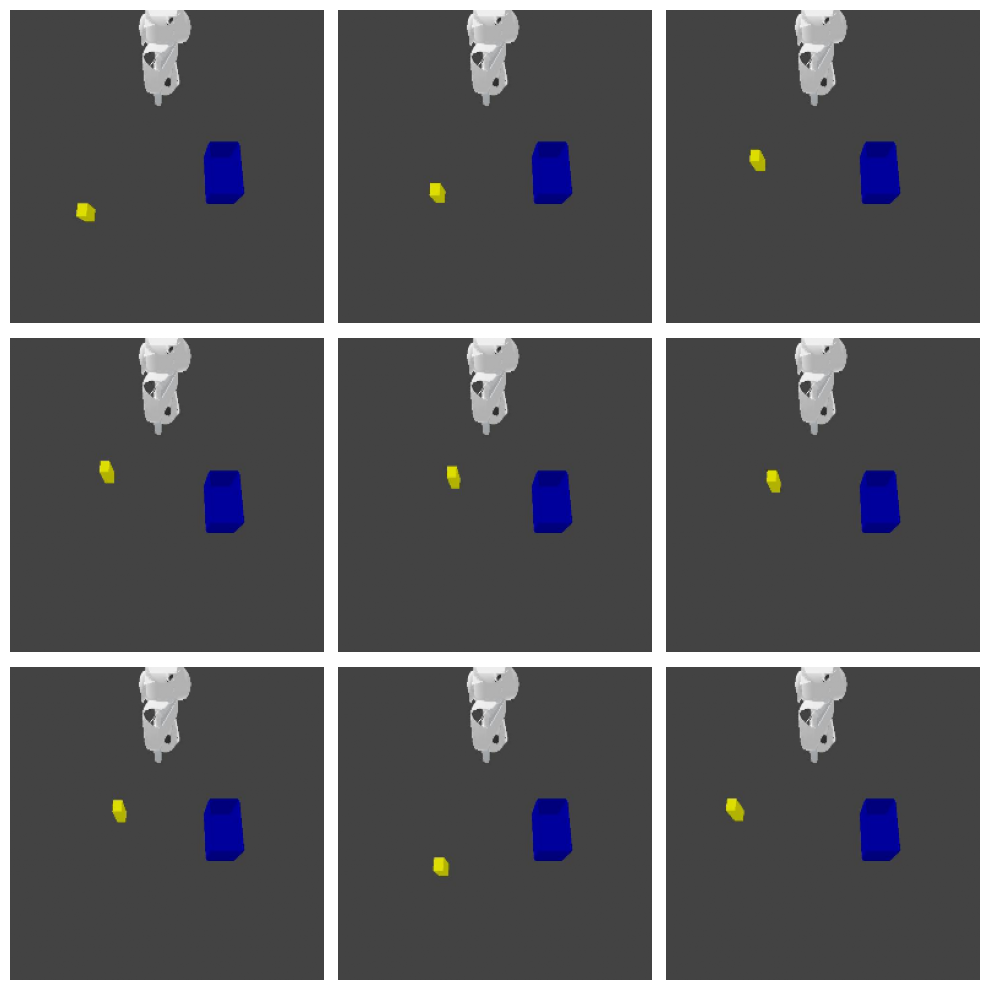

In [3]:
im_paths = [f"{DATA_PATH}/{dir}/images/0000.jpg" for dir in dirs]
X = images_to_np_array_from_im_paths(im_paths, image_dim=256)
num_images = X.shape[0]
rand_indices = np.random.choice(num_images, size=9, replace=False)
rand_images = [np.transpose(X[i], (1, 2, 0)) for i in rand_indices]
plot_image_grid(rand_images)

In [4]:
# Create output data: waypoint collections from the paths
ways = []
for i, ep_path in tqdm(enumerate(dirs)):
    pos, quat, gripper_widths = from_sim_get_poses_n_gripper(f"{DATA_PATH}/{ep_path}/proprioceptives.txt")
    ways.append(pickplace_task_waypoints(pos, gripper_widths))
ways = np.array(ways)

y = ways.reshape(ways.shape[0], -1)
del ways
np.save('./datasets/latent_to_waypoints/direct_y.npy', y)
y = np.load('./datasets/latent_to_waypoints/direct_y.npy')
print(y.shape)

4911it [02:54, 28.15it/s]

(4911, 9)


In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_tensor = torch.tensor(X_train, dtype=torch.float)
y_train_tensor = torch.tensor(y_train, dtype=torch.float)
X_val_tensor = torch.tensor(X_test, dtype=torch.float)
y_val_tensor = torch.tensor(y_test, dtype=torch.float)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=128, shuffle=True)

In [6]:
model = ImageRegressor(IMAGE_RESIZE, 9).to(device)
model = train(model, device, train_loader, val_loader, n_epochs=200, lr=1e-3)

Epoch 1,	 Train Loss: 0.051017,	 Val Loss: 0.005359
Epoch 2,	 Train Loss: 0.013117,	 Val Loss: 0.003855
Epoch 3,	 Train Loss: 0.010170,	 Val Loss: 0.003403
Epoch 4,	 Train Loss: 0.008782,	 Val Loss: 0.003461
Epoch 5,	 Train Loss: 0.007570,	 Val Loss: 0.003227
Epoch 6,	 Train Loss: 0.006946,	 Val Loss: 0.003106
Epoch 7,	 Train Loss: 0.006329,	 Val Loss: 0.002955
Epoch 8,	 Train Loss: 0.005397,	 Val Loss: 0.002739
Epoch 9,	 Train Loss: 0.004410,	 Val Loss: 0.002475
Epoch 10,	 Train Loss: 0.003862,	 Val Loss: 0.002254
Epoch 11,	 Train Loss: 0.003513,	 Val Loss: 0.002083
Epoch 12,	 Train Loss: 0.003479,	 Val Loss: 0.001943
Epoch 13,	 Train Loss: 0.003260,	 Val Loss: 0.001801
Epoch 14,	 Train Loss: 0.002987,	 Val Loss: 0.001692
Epoch 15,	 Train Loss: 0.002785,	 Val Loss: 0.001596
Epoch 16,	 Train Loss: 0.002796,	 Val Loss: 0.001507
Epoch 17,	 Train Loss: 0.002564,	 Val Loss: 0.001422
Epoch 18,	 Train Loss: 0.002565,	 Val Loss: 0.001348
Epoch 19,	 Train Loss: 0.002403,	 Val Loss: 0.001287
Ep

In [7]:
y_pred = model(torch.Tensor(X_test).to(device)).cpu().detach().numpy()

errors = y_test - y_pred
errors = errors[:, :2]
errors = [np.linalg.norm(e) for e in errors]
mean_error = sum(errors)/len(errors)
devs = [abs(e-mean_error) for e in errors]
dev_error = sum(devs)/len(devs)

print("Avg. dist. from desired point (m): ", mean_error)
print("Avg. dev. from desired point (m): ", dev_error)

Avg. dist. from desired point (m):  0.0063421641138569265
Avg. dev. from desired point (m):  0.0026235288148210617


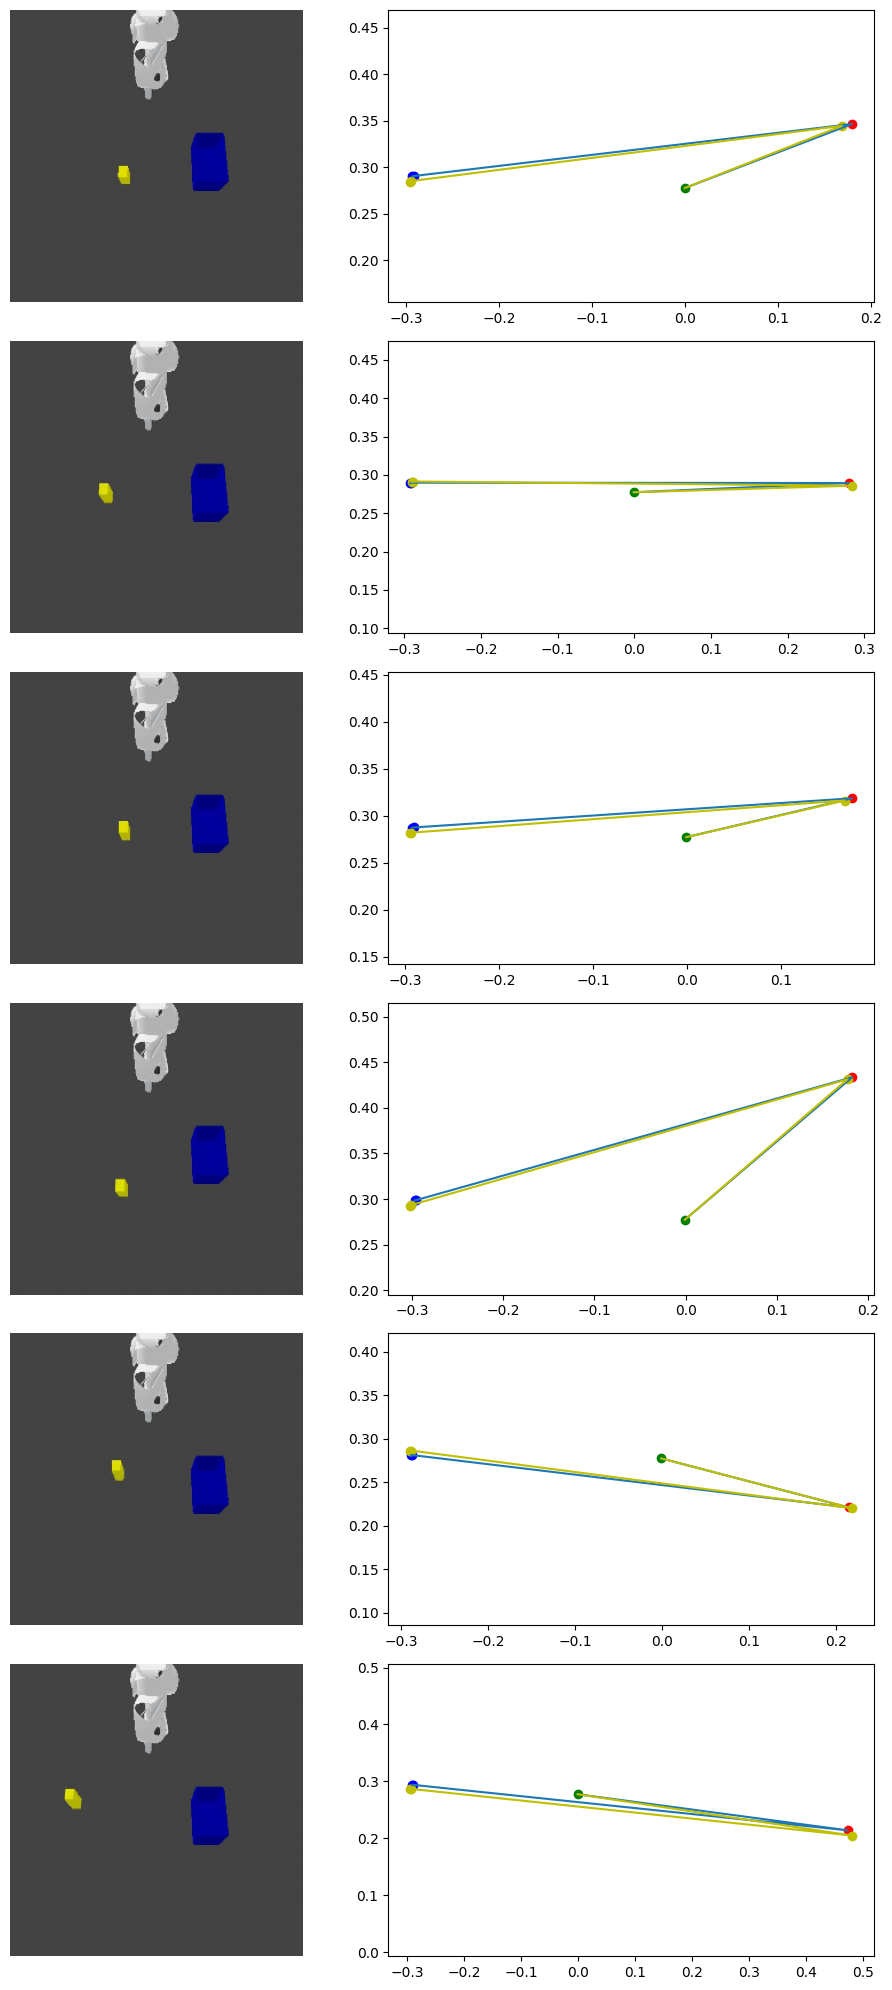

: 

In [8]:
example_count = 6
rand_indices = np.random.choice(list(range(len(X_test))), size=example_count)

imgs = X_test[rand_indices]
pred_waypoints = model(torch.Tensor(imgs).to(device)).cpu().detach().numpy()
imgs = np.transpose(imgs, (0, 2, 3, 1))

target_waypoints = y_test[rand_indices].reshape(6, 3, 3)
pred_waypoints = pred_waypoints.reshape(6, 3, 3)

plot_waypoints_and_initial_image(pred_waypoints, target_waypoints, imgs, save_path=f"{model.path}/results.png")